<a href="https://colab.research.google.com/github/FunmilolaAdetuwo/Research-Methods-7PAM2015-Large-Language-models-LLMs-Assignment/blob/main/LLM_SMS_Spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Advanced Spam Detection in SMS: Leveraging LLM Techniques with DistilBERT for Real-Time Classification**

NAME: ADETUWO FUNMILOLA OLATOUN

STUDENT NO: 22026993

Colab Notebook Link: https://colab.research.google.com/drive/18HboASKlz-Jhs8hobXN6N9ygyZOrXLrY?usp=sharing

Github Link :


## **INTRODUCTION**

The spread of spam messages is one of the issues brought about by the fast growth of online communication in the modern digital age. Not only do these unsolicited communications clog our email accounts, but they also present serious security threats because they frequently act as conduits for malware and phishing scams. Machine learning models are being used more and more to automatically classify and filter out spam messages in an effort to counteract this.
In this task, a large language model (LLM) called DistilBERT—a more effective variant of BERT—will be used to construct and implement a spam detection model. Sorting SMS messages into "spam" and "ham" (non-spam) categories is the goal of this task. The Hugging Face platform provided the SMS Spam Collection dataset, which comprises 5,572 texts classified as spam or ham, for this use. To effectively train the model to discern between undesirable spam and valid messages, the dataset offers a wealth of resources. The model is deployed via Flask after it has been trained, enabling real-time spam detection. The purpose of this task is to improve the efficacy and precision of spam detection systems by utilising advanced natural language processing techniques to solve the persistent problem of spam. The use of LLMs in spam detection marks a significant advancement in the field, offering improved accuracy and the ability to handle complex language patterns, as demonstrated in several NLP studies (Devlin et al., 2019; Sanh et al., 2019)



In [5]:
# installing the tools that will be used for building, fine-tuning and deploying LLMs when working with Natural language processing dataset

!pip install transformers datasets torch
!pip install keras-tuner
!pip install optuna
!pip install wordcloud
!pip install Flask


In [8]:
# Loading the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from wordcloud import WordCloud
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertForSequenceClassification, AdamW, BertTokenizer, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, f1_score
import keras_tuner as kt
import optuna
import torch
from torch.cuda.amp import GradScaler, autocast
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from flask import Flask, request, jsonify



## **Methodology**

This task uses a large language model (LLM), specifically DistilBERT, a quicker and lighter variant of BERT (Bidirectional Encoder Representations from Transformers), in an organised manner to create and implement a spam detection model. The approach comprises multiple pivotal phases, all of which are derived from existing literature and best approaches in natural language processing (NLP) and machine learning.

The SMS Spam Collection dataset is used for this task; it is well-known in the industry for its fair representation of both spam and ham (non-spam) texts. This dataset, which comes from the Hugging Face platform, has 5,572 labelled messages in it, making it a reliable source for testing and training machine learning models for spam detection applications (Almeida et al., 2011).





In [14]:
# Let's load the SMS Spam Collection Dataset
dta = load_dataset("sms_spam")

In [15]:
# then, we will convert the data to a Pandas DataFrame
dt = pd.DataFrame(dta['train'])

In [16]:
# showing the few rows of the dataset
print(dt.head())

                                                 sms  label
0  Go until jurong point, crazy.. Available only ...      0
1                    Ok lar... Joking wif u oni...\n      0
2  Free entry in 2 a wkly comp to win FA Cup fina...      1
3  U dun say so early hor... U c already then say...      0
4  Nah I don't think he goes to usf, he lives aro...      0


## **1. Exploratory Data Analysis (EDA)**

In order to obtain information about the distribution of spam and ham messages, the length of the messages, and common word usage, EDA was applied to the SMS Spam Collection dataset in this task.

The distribution of labels within the dataset was examined using EDA. The sample is noticeably unbalanced, with the bulk of messages being labelled as ham, as the bar plot illustrates. In particular, only over 13% of the messages are classified as spam, whereas about 87% of them are ham.

There are no missing values in the dataset, which makes the pre-processing stages easier. The distribution insights were validated by the descriptive statistics of the labels, which showed a mean label value near zero, which indicated the predominance of ham messages.

Word clouds were created for the spam and ham categories in order to obtain more in-depth understanding of the message content. Words that are commonly seen in spam content that tries to entice readers with offers or urgent prompts, such "free," "call," "text," and "win," are heavily included in the word cloud for spam messages. In comparison, the word cloud for ham messages displays a more conversational and broad vocabulary, with terms like "now," "will," "get," and "time," all of which are suggestive of casual, everyday communication.

Word clouds and label distribution provide insights that is crucial for setting up the tokeniser and fine-tuning the model's hyperparameters so that it can categorise messages more accurately—even when spam isn't very common.








In [17]:
# lets starts by checking the shape of the dataset
print(f"Data Shape Dataset: {dt.shape}")


Data Shape Dataset: (5574, 2)


In [18]:
# let's check if we have missing values
print(dt.isnull().sum())

# then check the summary statistics
print(dt.describe())


sms      0
label    0
dtype: int64
             label
count  5574.000000
mean      0.134015
std       0.340699
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


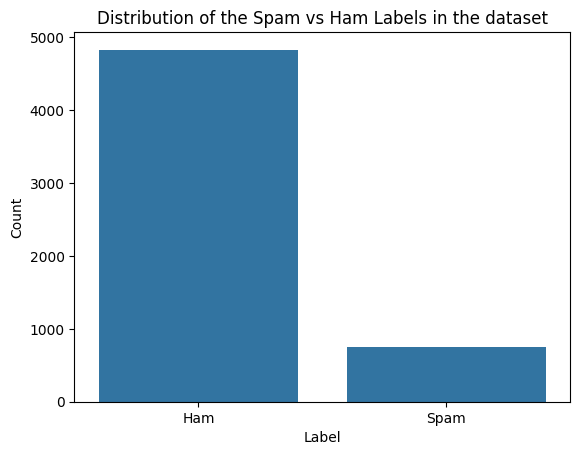

In [19]:
# let's show the distribution of our target variable

sns.countplot(x='label', data=dt)
plt.title('Distribution of the Spam vs Ham Labels in the dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'])
plt.show()


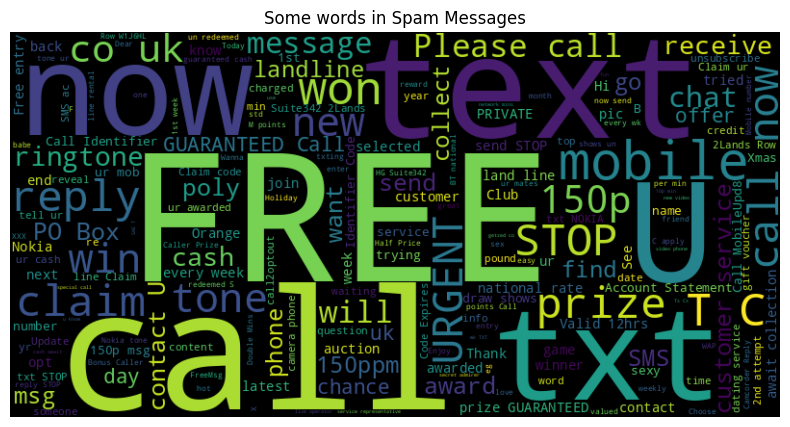

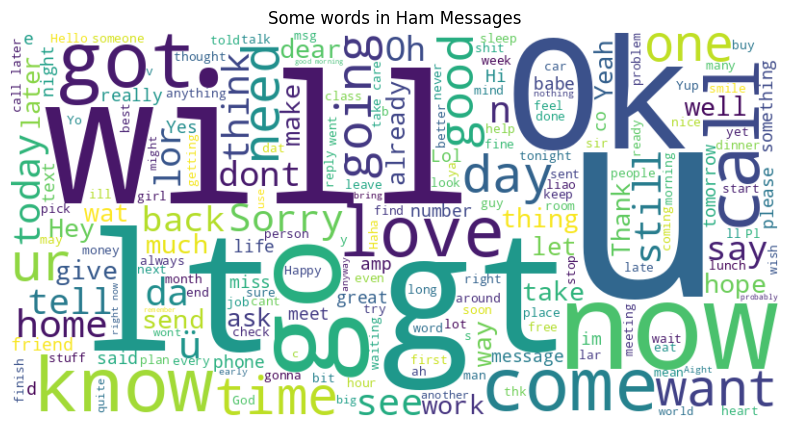

In [21]:
# we will show some of the most common words in the review using word clouds
spam_mssg = ' '.join(dt[dt['label'] == 1]['sms'])
ham_mssg = ' '.join(dt[dt['label'] == 0]['sms'])

# Checking some words in Spam messages
wdcd_spm = WordCloud(width=800, height=400, background_color='black').generate(spam_mssg)
plt.figure(figsize=(10, 5))
plt.imshow(wdcd_spm, interpolation='bilinear')
plt.title('Some words in Spam Messages')
plt.axis('off')
plt.show()

# Checking some words in Ham messages
wdcd_hm = WordCloud(width=800, height=400, background_color='white').generate(ham_mssg)
plt.figure(figsize=(10, 5))
plt.imshow(wdcd_hm, interpolation='bilinear')
plt.title('Some words in Ham Messages')
plt.axis('off')
plt.show()

## **2. Data Preprocessing**

An essential first step in getting the SMS Spam Collection dataset ready for DistilBERT model training is data pre-processing. Tokenisation using the DistilBERT tokeniser, which turns text messages into number tokens, was the first step in the process. This is significant because in order for the model to comprehend and analyse the text data, these tokens are required. For model compatibility, we employed a pre-trained 'distilbert-base-uncased' tokeniser. To help the model concentrate on the messages' actual content, padding and attention masks were added to each tokenised message, which resulted in a uniform length of 256 tokens.

The data was tokenised before being transformed into tensors, which are the fundamental data structures used in PyTorch computation. The data was then divided into training, validation, and test sets and arranged into a TensorDataset.

To be precise, 80% of the data was allocated for training, with the remaining 20% set aside for testing. The training data was further split, with 90% used for actual training and 10% for validation. This split permits performance evaluation on unseen data both during and after training, ensuring that the model is trained on a significant amount of the data.

The dataset was loaded into DataLoader objects, which manage data batching and shuffles, to expedite the training process. Because batching enables the model to process several samples in parallel, it is very crucial for speeding up the training process. In order to balance the requirements of efficient computation with the limitations of the hardware available, a batch size of 32 was used.






In [22]:
# let us start with tokenization with DistilBERT tokenizer

# first, we will be Initializing the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [23]:
# Define a function
def tokenize_batch(batch):
    return tokenizer(batch['sms'], padding='max_length', truncation=True, max_length=256)

# Applying tokenization
encoded_data = dt.apply(lambda x: tokenizer.encode_plus(
    x['sms'],
    add_special_tokens=True,
    max_length=256,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt'
), axis=1)

# Converting the data to tensors and creating a DataLoader
inpt_id = torch.stack([item['input_ids'] for item in encoded_data])
attion_mask = torch.stack([item['attention_mask'] for item in encoded_data])
lbls = torch.tensor(dt['label'].values)

dta = TensorDataset(inpt_id, attion_mask, lbls)

In [25]:
#  We will then be splitting the data into training, test and validation sets
# we will first split the original data into 80% for training, 20% for test data, then we will futher split the training data into 90% for training, and 10% for validation set
tn_dt, tst_dt = train_test_split(dta, test_size=0.2, random_state=42)
trn_dt, vld_dt = train_test_split(tn_dt, test_size=0.1, random_state=42)

# Checking the size of the splits
print(f"Training set size: {len(trn_dt)}")
print(f"Validation set size: {len(vld_dt)}")
print(f"Test set size: {len(tst_dt)}")

Training set size: 4013
Validation set size: 446
Test set size: 1115


In [26]:
# Creating the DataLoaders for the dataset
batch_size = 32

trn_lder = DataLoader(trn_dt, batch_size=batch_size, shuffle=True)
vld_lder = DataLoader(vld_dt, batch_size=batch_size, shuffle=False)
tst_lder = DataLoader(tst_dt, batch_size=batch_size, shuffle=False)

## **3. Model Selection, Fine-Tuning and Training**

The pre-trained 'distilbert-base-uncased' configuration was used to load the DistilBERT model since it is more lightweight than the complete BERT model and well-suited for LLM tasks. In order to handle binary classification, the model was set up with num_labels=2, which corresponds to the two possible results: ham or spam.

Using the SMS dataset, the DistilBERT model was fine-tuned during the training phase. The optimiser used was AdamW, whose efficient weight decay handling makes it a good fit for transformer models. In order to fine-tune BERT-based models, the learning rate was adjusted at 2e-5.

The average training loss and accuracy were determined at the conclusion of each epoch to keep a careful eye on the training process. The average training loss considerably decreased during the epochs, indicating the model's outstanding performance. The model had successfully learnt to categorise the messages in the training set by the third epoch, when the average training accuracy hit 100%.

These findings show that the DistilBERT model is effective at differentiating between spam and ham communications once it has been fine-tuned.



In [27]:
# Selecting the model
# setting the device to GPU
device = 'cuda'

# Loading the BERT model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [32]:
print(f'b_input_ids shape: {inpt_id.shape}')
print(f'b_input_mask shape: {attion_mask.shape}')
print(f'b_labels shape: {lbls.shape}')


b_input_ids shape: torch.Size([5574, 1, 256])
b_input_mask shape: torch.Size([5574, 1, 256])
b_labels shape: torch.Size([5574])


In [35]:
# we will now start with Fine-Tuning and Training

# we will define the optimizer
optzer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 3
ttl_step = len(trn_lder) * epochs

# Creating the learning rate scheduler
schdler = get_linear_schedule_with_warmup(optzer, num_warmup_steps=0, num_training_steps=ttl_step)

# Defining a function to calculate the accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# The Training loop
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    model.train()

    total_loss = 0
    train_accuracy = 0

    for step, batch in enumerate(trn_lder):
        b_input_ids = batch[0].to(device).squeeze(1)
        b_input_mask = batch[1].to(device).squeeze(1)
        b_labels = batch[2].to(device)


        model.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optzer.step()
        schdler.step()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.cpu().numpy()

        train_accuracy += flat_accuracy(logits, label_ids)

    avg_trn_acrcy = train_accuracy / len(trn_lder)
    avg_trn_ls = total_loss / len(trn_lder)

    print(f'Average training loss: {avg_trn_ls}')
    print(f'Average training accuracy: {avg_trn_acrcy}')


Epoch 1/3
Average training loss: 0.013472477401794296
Average training accuracy: 0.9965277777777778
Epoch 2/3
Average training loss: 0.002582188085181683
Average training accuracy: 0.9990079365079365
Epoch 3/3
Average training loss: 0.0002653894449135156
Average training accuracy: 1.0


In [37]:
# The Validation loop
model.eval()
vld_acurcy = 0
nb_evl_step = 0

for batch in vld_lder:
    bh_inpt_id = batch[0].to(device).squeeze(1)
    bh_inpt_mask = batch[1].to(device).squeeze(1)
    bh_lbel = batch[2].to(device)

    with torch.no_grad():
        outputs = model(bh_inpt_id, attention_mask=bh_inpt_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    lbel_id = bh_lbel.cpu().numpy()

    vld_acurcy += flat_accuracy(logits, lbel_id)
    nb_evl_step += 1

print(f'Validation accuracy: {vld_acurcy/nb_evl_step}')



Validation accuracy: 0.984375


## **4. Evaluation**

Every batch of the test SMS messages was processed by the model throughout evaluation, and predictions were produced by modifying input IDs and attention masks for compatibility. The predictions of the model were then cross-checked against the true labels in order to compute important metrics such as accuracy, precision, recall, and F1-score, which evaluated the model's capacity to distinguish between spam and ham messages.

The model achieved a total accuracy of 99.55% on the test set, demonstrating outstanding performance. With 98.76% recall and 98.15% precision in spam identification, it performed especially well. This indicates that the model minimises errors and correctly identifies the majority of spam messages. The model is well-calibrated for this job, as evidenced by the high F1-score of 98.45%, which strikes a compromise between precision and recall. With only a few misclassifications—three ham communications were incorrectly labelled as spam, and two spam messages were incorrectly categorised as ham—the classification report and confusion matrix attest to its efficacy and dependability for real-world spam detection.



In [38]:
# Testing the model and showing the evaluation metrics
# first we will put the model in an evaluation mode
model.eval()

# Initializing the lists to store true labels and predictions
true_lbel = []
prdtion = []

# Looping over the test data
for step, batch in enumerate(tst_lder):
    print(f"Processing batch {step+1}/{len(tst_lder)}")

    bt_inpt_id = batch[0].to(device).squeeze(1)
    bt_inpt_mask = batch[1].to(device).squeeze(1)
    bt_lbel = batch[2].to(device)

    with torch.no_grad():
        outpt = model(bt_inpt_id, attention_mask=bt_inpt_mask)

    logits = outpt.logits
    logits = logits.detach().cpu().numpy()
    lbel_id = bt_lbel.cpu().numpy()

# Storing the true label & prediction
    prdtion.extend(np.argmax(logits, axis=1).flatten())
    true_lbel.extend(lbel_id.flatten())

# Ensuring that both arrays are the same length
if len(true_lbel) == len(prdtion):

# Calculating the accuracy, precision, recall, and F1-score
  acracy = accuracy_score(true_lbel, prdtion)
  precisn = precision_score(true_lbel, prdtion)
  recll = recall_score(true_lbel, prdtion)
  f1 = f1_score(true_lbel, prdtion)

  print(f'Test Accuracy: {acracy }')
  print(f'Precision: {precisn}')
  print(f'Recall: {recll}')
  print(f'F1-Score: {f1}')

# Generating  classification report
  print("\nClassification Report:")
  print(classification_report(true_lbel, prdtion, target_names=['Ham', 'Spam']))

# Generating  confusion matrix
  print("\nConfusion Matrix:")
  print(confusion_matrix(true_lbel, prdtion))

else:
  print("Mismatch in lengths of true labels and predictions. Review data processing.")


Processing batch 1/35
Processing batch 2/35
Processing batch 3/35
Processing batch 4/35
Processing batch 5/35
Processing batch 6/35
Processing batch 7/35
Processing batch 8/35
Processing batch 9/35
Processing batch 10/35
Processing batch 11/35
Processing batch 12/35
Processing batch 13/35
Processing batch 14/35
Processing batch 15/35
Processing batch 16/35
Processing batch 17/35
Processing batch 18/35
Processing batch 19/35
Processing batch 20/35
Processing batch 21/35
Processing batch 22/35
Processing batch 23/35
Processing batch 24/35
Processing batch 25/35
Processing batch 26/35
Processing batch 27/35
Processing batch 28/35
Processing batch 29/35
Processing batch 30/35
Processing batch 31/35
Processing batch 32/35
Processing batch 33/35
Processing batch 34/35
Processing batch 35/35
Test Accuracy: 0.9955156950672646
Precision: 0.9814814814814815
Recall: 0.9875776397515528
F1-Score: 0.9845201238390092

Classification Report:
              precision    recall  f1-score   support

     

## **5. Application and Deployment**
The next step was to store the tokeniser and model for subsequent usage after optimising the DistilBERT model for spam detection. To make sure the tokeniser and model could be quickly reloaded for inference, they were saved to a directory named./sms_spam_model. The model and tokeniser were saved and then loaded back into the environment in order to be used. To get ready to make predictions using fresh data, the model was placed in evaluation mode.

In order to classify text as "Spam" or "Ham," a function was developed to process new text input, tokenise it, and then run it through the model. This function produces the prediction, manages tokenisation, and modifies the input dimensions to make them compatible with the model.

Flask was used for deployment, allowing the model to be accessed through a web application. Users can send text data via a POST request by setting up a basic API with a /predict endpoint. The system is prepared for real-time spam detection by the model, which evaluates the input and returns the classification as a JSON response.



In [39]:
# Saving the fine-tuned model and tokenizer

# Saving the tokenizer
tokenizer.save_pretrained('./sms_spam_model')

# Saving the model
model.save_pretrained('./sms_spam_model')


In [40]:
# Loading the fine-tuned model and tokenizer for inference
# Now, Loading the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('./sms_spam_model')

# Loading the model
model = DistilBertForSequenceClassification.from_pretrained('./sms_spam_model')
model.eval()

# then, loading to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [41]:
# Creating a function that accepts fresh text data and outputs the spam classification
def predict_spam(text):
    # Tokenize the input text
    inp = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    inp_id = inp['input_ids'].to(device).squeeze(1)
    ation_mask = inp['attention_mask'].to(device).squeeze(1)

    with torch.no_grad():
        otpt = model(inp_id, attention_mask=ation_mask)

    logits = otpt.logits
    predted_cls_id = torch.argmax(logits, dim=1).item()

    if predted_cls_id == 1:
        return "Spam"
    else:
        return "Ham"


In [42]:
# Deploying the model using FLASK

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    text = data['text']
    prediction = predict_spam(text)
    return jsonify({'classification': prediction})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit


## **Conclusion**

In summary, the DistilBERT model was effectively used in this task to create and implement a spam detection system. The model's ability to distinguish between spam and ham messages was enhanced by achieving high accuracy, precision, and recall by fine-tuning on the SMS Spam Collection dataset. After that, a straightforward and user-friendly web service for real-time spam detection was made available by the model's deployment via Flask. This method offers a dependable and effective solution for spam filtering in a variety of scenarios by illustrating the useful application of large language models in tackling typical communication issues. In general, the research demonstrates how LLM may enhance digital communication.


## **REFERENCES:**

Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. In NAACL-HLT (pp. 4171-4186).

Almeida, T. A., Hidalgo, J. M. G., & Yamakami, A. (2011). Contributions to the study of SMS spam filtering: new collection and results. In Proceedings of the 11th ACM symposium on Document engineering (pp. 259-262).